<a href="https://colab.research.google.com/github/superasymmetry/CPSY1291_finalproject/blob/main/CPSY1291_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y jax jaxlib
!pip uninstall -y tensorflow-decision-forests tensorflow-text tf-keras

!pip install tensorflow==2.19.0

!pip install datasets==3.6.0

Found existing installation: jax 0.7.2
Uninstalling jax-0.7.2:
  Successfully uninstalled jax-0.7.2
Found existing installation: jaxlib 0.7.2
Uninstalling jaxlib-0.7.2:
  Successfully uninstalled jaxlib-0.7.2
Found existing installation: tensorflow_decision_forests 1.12.0
Uninstalling tensorflow_decision_forests-1.12.0:
  Successfully uninstalled tensorflow_decision_forests-1.12.0
Found existing installation: tensorflow-text 2.19.0
Uninstalling tensorflow-text-2.19.0:
  Successfully uninstalled tensorflow-text-2.19.0
Found existing installation: tf_keras 2.19.0
Uninstalling tf_keras-2.19.0:
  Successfully uninstalled tf_keras-2.19.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
import tensorflow as tf
import scipy.fftpack as fp
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import json

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


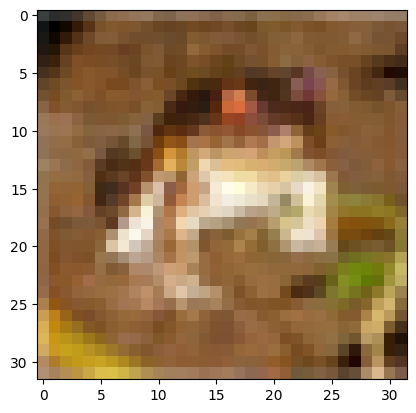

/tmp/ipython-input-2672651239.py:13: RuntimeWarning: Mean of empty slice.
  f = lambda r : processed[(R >= r-0.5) & (R < r+0.5)].mean()
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2480: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


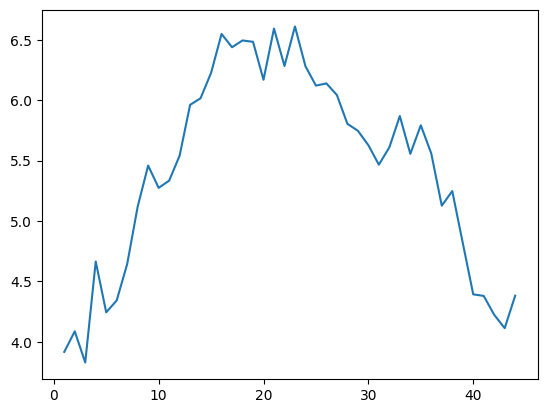

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
img = x_train[0]
plt.imshow(img)
plt.show()

transformed = fp.fft(fp.fft(img, axis=0), axis=1)
centered = fp.fftshift(transformed)
processed = np.log(abs(centered) + 1e-8)

x,y = np.meshgrid(np.arange(processed.shape[1]),np.arange(processed.shape[0]))
R = np.sqrt(x**2+y**2)

f = lambda r : processed[(R >= r-0.5) & (R < r+0.5)].mean()
r  = np.linspace(1,50,num=50)
mean = np.vectorize(f)(r)

fig,ax=plt.subplots()
ax.plot(r,mean)
plt.show()

In [12]:
!pip install datasets==3.6.0


##Remove frequencies

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

imagenette.py: 0.00B [00:00, ?B/s]

320px/train/0000.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

320px/validation/0000.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

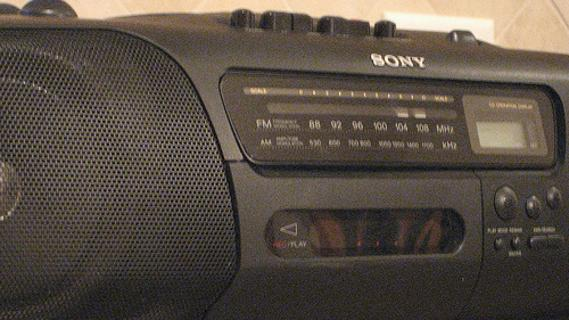

In [13]:
from datasets import load_dataset

ds = load_dataset("frgfm/imagenette", "320px")

image = ds["train"][0]["image"]
image

(320, 569)


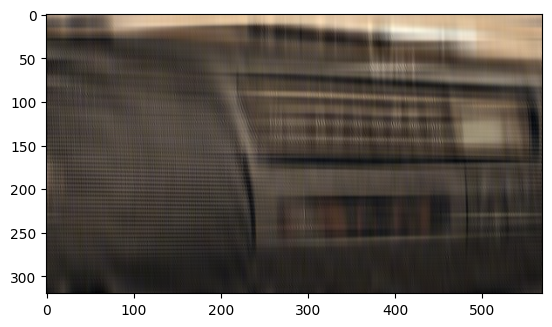

In [28]:
image_data = np.array(image)
image_red = image_data[:,:,0]
print(image_red.shape)
image_green = image_data[:,:,1]
image_blue = image_data[:,:,2]

def remove_freqs(img_data, threshold):
  image_fft = fp.fft2(img_data)

  rows, cols = img_data.shape
  freq_x = np.fft.fftfreq(cols, d=1.0)
  freq_y = np.fft.fftfreq(rows, d=1.0)

  for i in range(len(freq_x)):
    for j in range(len(freq_y)):
      if freq_x[i] > threshold and freq_y[j] > threshold:
        image_fft[j][i] = 0.0
        image_fft[rows - i][cols - j] = 0.0
        image_fft[rows - i][j] = 0.0
        image_fft[i][cols - j] = 0.0

  inverse = np.real(fp.ifft2(image_fft))
  return inverse

red_inverse = remove_freqs(image_red, 0.01)
green_inverse = remove_freqs(image_green, 0.01)
blue_inverse = remove_freqs(image_blue, 0.01)
inverse = np.stack([red_inverse, green_inverse, blue_inverse], axis=2)

img_norm = (inverse - inverse.min()) / (inverse.max() - inverse.min())
plt.imshow(img_norm)

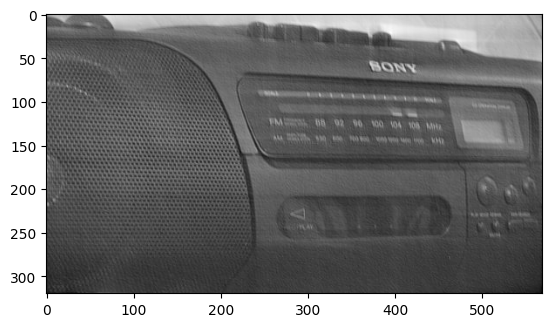

In [20]:
image_gray = np.mean(np.array(image).astype(float), axis=2)
gray_inverse = remove_freqs(image_gray, 0.001)

plt.imshow(gray_inverse, cmap='gray')
plt.show()

In [ ]:
import h5py
f = h5py.File("/content/efficientnetB0_harmonized.h5", mode="r+")
model_config_string = f.attrs.get("model_config")
if model_config_string.find('"groups": 1,') != -1:
    model_config_string = model_config_string.replace('"groups": 1,', '')
    f.attrs.modify('model_config', model_config_string)
    f.flush()
    model_config_string = f.attrs.get("model_config")
    assert model_config_string.find('"groups": 1,') == -1

f.close()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/efficientnetB0_harmonized.h5', errno = 2, error message = 'No such file or directory', flags = 1, o_flags = 2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Test harmonized model

In [ ]:
!wget https://storage.googleapis.com/serrelab/prj_harmonization/models/vgg16_harmonized.h5 -O vgg16_harmonized.h5

model = tf.keras.models.load_model("vgg16_harmonized.h5")

--2025-12-09 23:23:42--  https://storage.googleapis.com/serrelab/prj_harmonization/models/vgg16_harmonized.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 173.194.212.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1106996760 (1.0G) [application/octet-stream]
Saving to: ‘vgg16_harmonized.h5’

vgg16_harmonized.h5 100%[===================>]   1.03G  40.6MB/s    in 18s     

2025-12-09 23:24:00 (58.4 MB/s) - ‘vgg16_harmonized.h5’ saved [1106996760/1106996760]



In [ ]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-dog-royalty-free-image-505534037-1565105327.jpg -O sample_image.jpg

!gdown 13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj

--2025-12-09 23:23:29--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-dog-royalty-free-image-505534037-1565105327.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541440 (529K) [image/jpeg]
Saving to: ‘sample_image.jpg’

sample_image.jpg    100%[===================>] 528.75K  --.-KB/s    in 0.05s   

2025-12-09 23:23:29 (10.3 MB/s) - ‘sample_image.jpg’ saved [541440/541440]

Downloading...
From: https://drive.google.com/uc?id=13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj
To: /content/imagenet_classes.json
100% 32.6k/32.6k [00:00<00:00, 60.9MB/s]


In [29]:
#make sure running on gpu
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

#import VGG19 model
vgg16 = models.vgg16(weights="IMAGENET1K_V1").to(device)
vgg16.eval()


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:08<00:00, 66.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
#assess VGG16 on Imagenette
labels_imagenette = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
imagenette_indices = [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]

preprocess_im = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

#function specific for unharmonized model
def model_pred(outputs, class_labels):

  outputs_imagenette_specific = outputs[0, imagenette_indices]
  compute = F.softmax(outputs_imagenette_specific, dim=0)
  probability, predicted_class = torch.max(compute, dim=0)
  return str(labels_imagenette[predicted_class.item()])

def load_preprocess(img):
  image_tensor = preprocess_im(img)
  image_tensor.unsqueeze_(0)
  return image_tensor




In [31]:

#function for decoding for harmonized model
def decode_preds(outputs, class_names):
  # Assuming outputs is the tensor of model outputs
  outputs_imagenette_specific = outputs[0, imagenette_indices]
  softmax_outputs = np.exp(outputs_imagenette_specific) / np.sum(np.exp(outputs), axis=1, keepdims=True)
  softmax_outputs = torch.from_numpy(softmax_outputs)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[idx] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()
  return predicted_class_labels


In [32]:
# clean the dataset to remove greyscale images
from typing import List
from datasets import Dataset, DatasetDict

def remove_greyscale(dataset, set_names: List[str]):
  new_ds = DatasetDict()
  # initialize the lists for each set
  for i in range(len(set_names)):
    set_name = set_names[i]
    new_ds[set_name] = []
    for j in range(len(ds[set_name])):
      data = ds[set_name][j]
      image = data["image"]
      image_data = np.array(image)
      if len(image_data.shape) == 3:
        new_ds[set_name].append(data)
    Dataset.from_list(new_ds[set_name])
  return new_ds

new_ds = remove_greyscale(ds, ["validation"])


In [ ]:
#This shows how many grayscale images are filtered out
print('Number of grayscale images filtered out: ' + str(len(ds["validation"]) - len(new_ds["validation"])))


Number of grayscale images filtered out: 69


In [ ]:
import random
#testing vgg16 on all filtered images in validation
vgg16.eval()


correct = 0

for j in range(5):
  for m in range(100):
    random.randin


    ground_truth = labels_imagenette[new_ds["validation"][i]["label"]]
    im = load_preprocess(new_ds["validation"][i]["image"]).to(device)
    with torch.no_grad():
      output= vgg16(im)
    model_pred(output, labels_imagenette)
    predicted_label = model_pred(output, labels_imagenette)

    if predicted_label == ground_truth:
      correct += 1

accuracy = correct/len(new_ds["validation"])

final_acc = accuracy * 100
print(final_acc)


AttributeError: module 'random' has no attribute 'randin'

In [ ]:
#testing vgg16 on 5 batches 100 filtered images in validation
vgg16.eval()


correct = 0

for i in range(len(new_ds["validation"])):
  ground_truth = labels_imagenette[new_ds["validation"][i]["label"]]
  im = load_preprocess(new_ds["validation"][i]["image"]).to(device)
  with torch.no_grad():
    output= vgg16(im)
  model_pred(output, labels_imagenette)
  predicted_label = model_pred(output, labels_imagenette)

  if predicted_label == ground_truth:
    correct += 1

accuracy = correct/len(new_ds["validation"])

final_acc = accuracy * 100
print(final_acc)

KeyboardInterrupt: 

In [ ]:
#testing harmonized vgg16 on 1 filtered images in validation

vgg16.eval()


correct = 0

for i in range(1):
  ground_truth = labels_imagenette[new_ds["validation"][3000]["label"]]
  im = load_preprocess(new_ds["validation"][3000]["image"]).to(device)
  with torch.no_grad():
    output= vgg16(im)
  model_pred(output, labels_imagenette)
  predicted_label = model_pred(output, labels_imagenette)
  print(predicted_label)
  if predicted_label == ground_truth:
    correct += 1

accuracy = correct/1

final_acc = accuracy * 100
print(final_acc)


golf ball
100.0


In [ ]:

#testing harmonized vgg16 on all filtered images in validation

correct = 0

for i in range(len(new_ds["validation"])):
  ground_truth = labels_imagenette[new_ds["validation"][i]["label"]]
  img_preprocessed = preprocess_im(new_ds["validation"][i]["image"]).permute(1, 2, 0).unsqueeze(0)
  out = model.predict(img_preprocessed)
  predicted_labels = decode_preds(out,labels_imagenette)
  if predicted_labels[0] == ground_truth:
    correct += 1

accuracy = correct/1

final_acc = accuracy * 100
print(final_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
accuracy = correct/len(new_ds["validation"])

final_acc = accuracy * 100
print(final_acc)

99.76659751037344


In [ ]:

#testing harmonized vgg16 on 1 filtered images in validation
correct = 0

for i in range(1):
  ground_truth = labels_imagenette[new_ds["validation"][12]["label"]]
  img_preprocessed = preprocess_im(new_ds["validation"][12]["image"]).permute(1, 2, 0).unsqueeze(0)
  out = model.predict(img_preprocessed)
  predicted_labels = decode_preds(out,labels_imagenette)
  if predicted_labels[0] == ground_truth:
    correct += 1

accuracy = correct/1

final_acc = accuracy * 100
print(final_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
100.0


In [ ]:
#functions for accuracy

def unharmonized_acc(dataset, model):
  correct = 0
  all_acc = []

  for j in range(5):
    correct = 0
    for m in range(100):
      i = random.randint(1,len(dataset))
      ground_truth = labels_imagenette[dataset[i]["label"]]
      im = load_preprocess(dataset[i]["image"]).to(device)
      with torch.no_grad():
        output= model(im)
      model_pred(output, labels_imagenette)
      predicted_label = model_pred(output, labels_imagenette)

      if predicted_label == ground_truth:
        correct += 1

    accuracy = correct/100

    final_acc = accuracy * 100
    all_acc.append(accuracy)
    print('Accuracy Batch ' + str(j + 1) + ': '+ str(final_acc))

  print( 'Batch Variance: ' + str(statistics.variance(all_acc)))
  print( 'Standard Deviation: ' + str(math.sqrt(statistics.variance(all_acc))))
  print('Average Accuracy: ' + str((sum(all_acc)/5)*100))

def harmonized_acc(dataset, model):
  correct = 0
  all_acc = []

  for j in range(5):
    correct = 0
    for m in range(100):
      i = random.randint(1,len(dataset))
      ground_truth = labels_imagenette[dataset[i]["label"]]
      img_preprocessed = preprocess_im(dataset[i]["image"]).permute(1, 2, 0).unsqueeze(0)
      out = model.predict(img_preprocessed)
      predicted_labels = decode_preds(out,labels_imagenette)
      print(predicted_labels)

      if predicted_labels[0] == ground_truth:
        correct += 1

    accuracy = correct/100

    final_acc = accuracy * 100
    all_acc.append(accuracy)
    print('Accuracy Batch ' + str(j + 1) + ': '+ str(final_acc))

  print( 'Batch Variance: ' + str(statistics.variance(all_acc)))
  print( 'Standard Deviation: ' + str(math.sqrt(statistics.variance(all_acc))))
  print('Average Accuracy: ' + str((sum(all_acc)/5)*100))







In [ ]:
harmonized_acc(new_ds["validation"], model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
['gas pump']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
['parachute']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
['French horn']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
['gas pump']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
['French horn']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
['golf ball']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
['garbage truck']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
['gas pump']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
['golf ball']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
['English springer']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
['tench']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
['parachute']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
['garbage truck']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
['tench']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
['English springer']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
['chain saw']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
['English springer']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
['cassette player']
1/1 ━━━━━━━━━━━━━━━━━

### Create manipulated Dataset

In [ ]:
from PIL import Image
import random
def createManipulatedDataset(ds, set_names, batch_size, threshold):
  new_ds = DatasetDict()
  # initialize the lists for each set
  for i in range(len(set_names)):
    set_name = set_names[i]
    new_ds[set_name] = []
    random_sample = random.sample(range(len(ds[set_name])), batch_size)
    for j in range(batch_size):
      data = ds[set_name][random_sample[j]]
      image = data["image"]
      label = data["label"]
      image_data = np.array(image)
      image_red = image_data[:,:,0]
      image_green = image_data[:,:,1]
      image_blue = image_data[:,:,2]
      red_inverse = remove_freqs(image_red, threshold)
      green_inverse = remove_freqs(image_green, threshold)
      blue_inverse = remove_freqs(image_blue, threshold)
      inverse = np.stack([red_inverse, green_inverse, blue_inverse], axis=2)

      img_norm = (inverse - inverse.min()) / (inverse.max() - inverse.min())

      img_uint8 = (img_norm * 255).astype(np.uint8)

      pil_image = Image.fromarray(img_uint8)
      new_ds[set_name].append({
          "image": pil_image,
          "label": label
      })
    Dataset.from_list(new_ds[set_name])
  return new_ds





In [ ]:
manipulated_ds = createManipulatedDataset(new_ds, ["validation"], 100, 0.005)


In [ ]:
manipulated_ds['validation']

[{'image': <PIL.Image.Image image mode=RGB size=477x320>, 'label': 4},
 {'image': <PIL.Image.Image image mode=RGB size=426x320>, 'label': 6},
 {'image': <PIL.Image.Image image mode=RGB size=320x480>, 'label': 8},
 {'image': <PIL.Image.Image image mode=RGB size=320x426>, 'label': 7},
 {'image': <PIL.Image.Image image mode=RGB size=480x320>, 'label': 1},
 {'image': <PIL.Image.Image image mode=RGB size=426x320>, 'label': 6},
 {'image': <PIL.Image.Image image mode=RGB size=615x320>, 'label': 8},
 {'image': <PIL.Image.Image image mode=RGB size=426x320>, 'label': 0},
 {'image': <PIL.Image.Image image mode=RGB size=356x320>, 'label': 6},
 {'image': <PIL.Image.Image image mode=RGB size=322x320>, 'label': 4},
 {'image': <PIL.Image.Image image mode=RGB size=426x320>, 'label': 9},
 {'image': <PIL.Image.Image image mode=RGB size=320x480>, 'label': 7},
 {'image': <PIL.Image.Image image mode=RGB size=391x320>, 'label': 5},
 {'image': <PIL.Image.Image image mode=RGB size=320x457>, 'label': 4},
 {'ima

In [ ]:
vgg16.eval()

correct = 0

for i in range(100):
  ground_truth = labels_imagenette[manipulated_ds["validation"][i]["label"]]
  im = load_preprocess(manipulated_ds["validation"][i]["image"]).to(device)
  with torch.no_grad():
    output= vgg16(im)
  model_pred(output, labels_imagenette)
  predicted_label = model_pred(output, labels_imagenette)
  print(predicted_label)
  if predicted_label == ground_truth:
    correct += 1

accuracy = correct/100

final_acc = accuracy * 100
print(final_acc)

tench
cassette player
cassette player
chain saw
garbage truck
chain saw
French horn
French horn
cassette player
garbage truck
golf ball
gas pump
golf ball
tench
golf ball
chain saw
English springer
church
garbage truck
garbage truck
parachute
English springer
golf ball
parachute
church
English springer
chain saw
cassette player
parachute
tench
parachute
garbage truck
garbage truck
cassette player
French horn
French horn
gas pump
parachute
English springer
garbage truck
church
English springer
church
tench
English springer
golf ball
parachute
gas pump
tench
church
garbage truck
gas pump
parachute
cassette player
parachute
tench
parachute
gas pump
garbage truck
gas pump
parachute
English springer
church
chain saw
tench
golf ball
chain saw
tench
cassette player
parachute
church
English springer
parachute
church
English springer
church
gas pump
cassette player
gas pump
English springer
golf ball
English springer
chain saw
gas pump
tench
garbage truck
tench
golf ball
parachute
garbage truck

In [7]:
!git clone https://github.com/bethgelab/model-vs-human.git
%cd model-vs-human
!pip install -e .

Cloning into 'model-vs-human'...
remote: Enumerating objects: 855, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 855 (delta 182), reused 147 (delta 146), pack-reused 605 (from 1)
Receiving objects: 100% (855/855), 26.90 MiB | 24.90 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/model-vs-human
Obtaining file:///content/model-vs-human
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP to /tmp/pip-install-jyy5jiyl/clip_6fec0687bdcd495189d5be394710ddb6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP /tmp/pip-install-jyy5jiyl/clip_6fec0687bdcd495189d5be394710ddb6
  Resolved https://github.com/openai/CLIP to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [5]:
# get stylized dataset
!git clone https://github.com/rgeirhos/texture-vs-shape.git

Cloning into 'texture-vs-shape'...
remote: Enumerating objects: 2375, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 2375 (delta 31), reused 154 (delta 28), pack-reused 2210 (from 1)
Receiving objects: 100% (2375/2375), 148.67 MiB | 40.25 MiB/s, done.
Resolving deltas: 100% (257/257), done.


In [10]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/texture-vs-shape/stimuli/style-transfer-preprocessed-512"

def get_rand_img_styletransfer(root=root):
  # random object class folder
  class_folder = random.choice(os.listdir(root))
  class_path = os.path.join(root, class_folder)
  while not os.path.isdir(class_path):
      class_folder = random.choice(os.listdir(root))
      class_path = os.path.join(root, class_folder)

  # random image file from the chosen class folder
  images = [f for f in os.listdir(class_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
  image_file = random.choice(images)
  image_path = os.path.join(class_path, image_file)
  img = Image.open(image_path)
  label = class_folder
  return {"image": img, "label": label}

  print("class: ", class_folder)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [11]:
import os
import random
from PIL import Image

root = "/content/texture-vs-shape/stimuli/style-transfer-preprocessed-512"

def createStylizedDataset(root, num_samples=20):
    dataset = []
    class_folders = [f for f in os.listdir(root) if os.path.isdir(os.path.join(root, f))]

    for _ in range(num_samples):
        sample = get_rand_img_styletransfer(root)
        dataset.append(sample)

    return dataset

dataset_dict = createStylizedDataset(root, num_samples=20)
print(dataset_dict)

[{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0ED160>, 'label': 'truck'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0ED6D0>, 'label': 'bird'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0ED730>, 'label': 'bird'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0ED5B0>, 'label': 'bear'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0EDDC0>, 'label': 'car'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0ECDD0>, 'label': 'bottle'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0EDBB0>, 'label': 'truck'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0EDAC0>, 'label': 'cat'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0EDEE0>, 'label': 'dog'}, {'image': <PIL.Pn